In [1]:
import re 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime,date

In [2]:
#loading the AIRBNB dataset from CSV file 
airbnb = pd.read_csv(r"F:\DATA Analysis\Airbnb project file\1.AIRBNB raw.csv")

In [3]:
# Checking first 5 records from AIRBNB Data
airbnb.head()

,Unnamed: 0,id,name,rating,reviews,host_name,host_id,address,features,amenities,...,price,country,bathrooms,beds,guests,toiles,bedrooms,studios,checkin,checkout
0,0,49849504,Perla bungalov,4.71,64,Mehmetcan,357334205.0,"Kartepe, Kocaeli, Turkey","2 guests,2 bedrooms,1 bed,1 bathroom","Mountain view,Valley view,Lake access,Kitchen,...",...,8078,Turkey,1,1,2,0,2,0,Flexible,12 00 pm
1,1,50891766,Authentic Beach Architect Sheltered Villa with...,New,0,Fatih,386223873.0,"Kaş, Antalya, Turkey","4 guests,2 bedrooms,2 beds,2 bathrooms","Kitchen,Wifi,Dedicated workspace,Free parking ...",...,4665,Turkey,2,2,4,0,2,0,4 00 pm - 11 00 pm,10 00 am
2,2,50699164,cottages sataplia,4.85,68,Giorgi,409690853.0,"Imereti, Georgia","4 guests,1 bedroom,3 beds,1 bathroom","Mountain view,Kitchen,Wifi,Dedicated workspace...",...,5991,Georgia,1,3,4,0,1,0,After 1 00 pm,12 00 pm
3,3,49871422,Sapanca Breathable Bungalow,5.0,13,Melih,401873242.0,"Sapanca, Sakarya, Turkey","4 guests,1 bedroom,2 beds,1 bathroom","Mountain view,Valley view,Kitchen,Wifi,Free pa...",...,11339,Turkey,1,2,4,0,1,0,After 2 00 pm,12 00 pm
4,4,51245886,Bungalov Ev 2,New,0,Arp Sapanca,414884116.0,"Sapanca, Sakarya, Turkey","2 guests,1 bedroom,1 bed,1 bathroom","Kitchen,Wifi,Free parking on premises,TV,Air c...",...,6673,Turkey,1,1,2,0,1,0,After 2 00 pm,12 00 pm


## TOTAL RECORDS

In [4]:
print("Total records (rows) in the dataset : {}".format(airbnb.shape[0]))
print("Total columns (Columns) in the dataset : {}".format(airbnb.shape[1]))

Total records (rows) in the dataset : 12805
Total columns (Columns) in the dataset : 23


## 1. Dropping Irrelevent Columns
0 is an irrelevent column. Hence it should be dropped.

In [5]:
#dropping first columnn
airbnb = airbnb.drop(airbnb.columns[0], axis=1)
#dropping features column as there are same value columns in df
airbnb.drop('features', axis=1, inplace=True)
#dropping image links. its not required 
airbnb.drop('img_links',axis=1, inplace=True)
#host name is not relevant 
airbnb.drop('host_name', axis=1, inplace=True)
#only required country name so dropping address 
airbnb.drop('address', axis=1, inplace =True)

In [6]:
#minor corrections 
airbnb = airbnb.rename(columns={'toiles': 'toilets'})

## 2. Checking missing values

In [7]:
airbnb.isnull().sum()

id                 0
name               0
rating             0
reviews            0
host_id            0
amenities          0
safety_rules       0
hourse_rules       0
price              0
country            0
bathrooms          0
beds               0
guests             0
toilets            0
bedrooms           0
studios            0
checkin          800
checkout        2450
dtype: int64

*it has been observed that the checkin and checkout column has some missing values 
the best approach to treat the missing values is to imput them with the common checkin and checkout timings from all the time as most or the timings are genrally same in many hotels  

*As for the checkin column has the string value (Flexible) so it would throw the error while converting them to the date and time format 
the approach to deal with it would be to create a new column with values (YES) and (NO) indicate does the hotel provide flexible timings or not and at the place of cell where flexible is written we will be imputing this with the 0:00 time ( to not show it as NA value) 

## 3. CHECKIN VALUES 

In [8]:
# 1- creating the new column called flexible checking 

airbnb['Flexible_Checkin'] = airbnb['checkin'].apply(lambda x: 'YES' if isinstance(x, str) and 'flexible' in x.lower() else 'NO' )

In [9]:
# 2- imputing flexible values with the 00:01

airbnb['checkin'] = airbnb['checkin'].apply(lambda x: "00:01" if isinstance(x, str) and 'flexible' in x.lower() else x)

In [10]:
# 3-removing (after) from values in the checkin column 

airbnb['checkin'] = airbnb['checkin'].apply(lambda x: x.replace('After', '').strip() if isinstance(x, str) else x)

In [11]:
# 4-imputing checkin null values with common ones 

checkin_mode = airbnb['checkin'].mode().iloc[0]  #find mode of the checkin column i.e (3:00 pm)
airbnb['checkin'] = airbnb['checkin'].replace('NA', pd.NA)  # Replace 'NA' strings with NaN
airbnb['checkin'] = airbnb['checkin'].fillna(checkin_mode)  # Replace NaN values with the mode

In [12]:
airbnb['checkin'].isnull().sum()

0

In [13]:
# 5-Function to extract the start time because unable to parse time range into datetime datatype 

def extract_start_time(time_str):
    start_time = time_str.split('-')[0].strip()
    start_time = ' '.join(start_time.split()[:-2] + start_time.split()[-2:])
    return start_time

airbnb['checkin']= airbnb['checkin'].apply(extract_start_time)

In [14]:
# 6-Formating the values as desired 
def parse_and_format_time(time_str):
    formats = [
        '%I %M %p',  # 12 01 am
        '%I:%M %p',  # 12:01 am
        '%H:%M'      # 12:01 (24-hour format)
    ]
    for fmt in formats:
        try:
            dt = pd.to_datetime(time_str, format=fmt)
            return dt
        except ValueError:
            continue

    return None
    
airbnb['checkin'] = airbnb['checkin'].apply(parse_and_format_time)

# Formating it back to 12-hour format with AM/PM
airbnb['checkin'] = airbnb['checkin'].dt.strftime('%I:%M %p').str.lower()

In [15]:
airbnb['checkin'].head(5)

0    12:01 am
1    04:00 pm
2    01:00 pm
3    02:00 pm
4    02:00 pm
Name: checkin, dtype: object

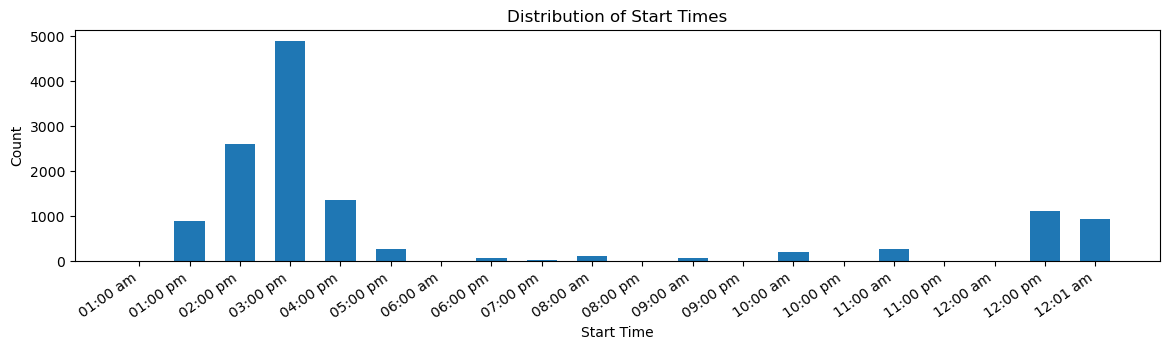

In [16]:
plt.figure(figsize=(14, 3)) 

time_counts = airbnb['checkin'].value_counts().sort_index()  # Call the value_counts() function
bars = plt.bar(time_counts.index, time_counts.values, width=0.6)

# Customize the plot
plt.title('Distribution of Start Times')
plt.xlabel('Start Time')
plt.ylabel('Count')
plt.xticks(rotation=35, ha='right')
plt.show()

#required itme format has achieved , will change later if required  
   ##12:01 is imputation where flexible was written in the original data as to avoide further errors 



### 4. CHECKOUT VALUES

In [17]:
airbnb['checkout'].isnull().sum()

2450

In [18]:
#imputing null values with the common checkout time from all the times 

checkout_mode = airbnb['checkout'].mode().iloc[0]#find mode of the checkin column i.e (11:00 am)
airbnb['checkout'] = airbnb['checkout'].replace('NA', pd.NA) # Replace 'NA' strings with NaN
airbnb['checkout'] = airbnb['checkout'].fillna(checkout_mode)# Replace NaN values with the mode

In [19]:
airbnb['checkout'].isnull().sum()

0

In [20]:
# 6-Formating the values as desired 

def convert_checkout_time_today(time_str):
    time_str = time_str.strip().lower()
    try:
        time_obj = datetime.strptime(time_str, '%I %M %p')
        return datetime.combine(date.today(), time_obj.time())
    except ValueError:
        print(f"Could not parse time string: {time_str}")
        return pd.NaT

airbnb['checkout']=airbnb['checkout'].apply(convert_checkout_time_today)

airbnb['checkout']=airbnb['checkout'].dt.strftime('%I:%M %p').str.lower()

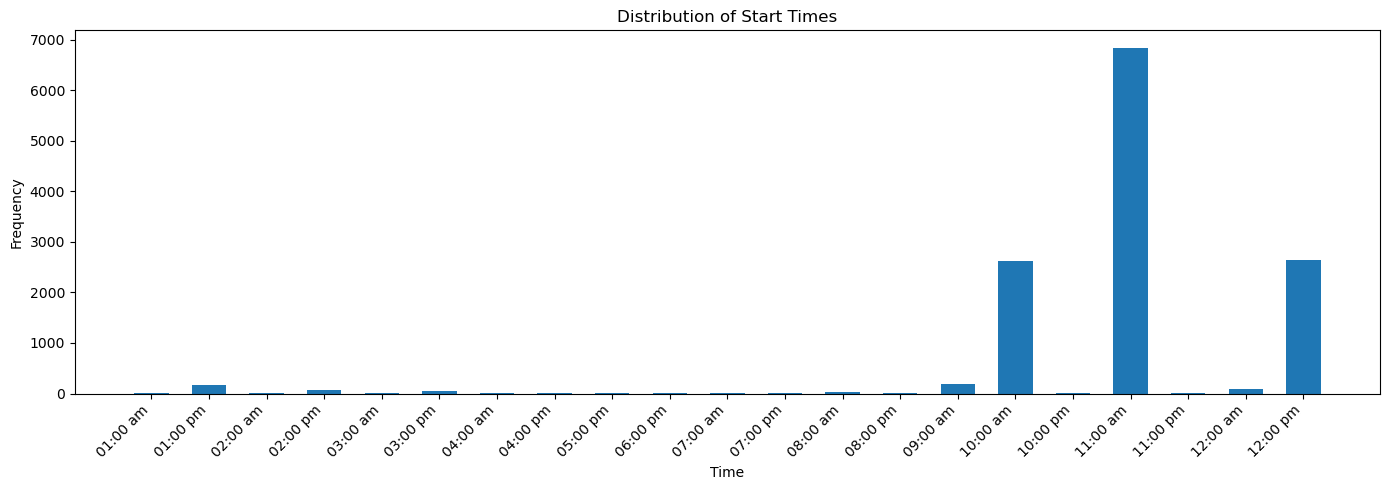

In [21]:
plt.figure(figsize=(14, 5)) 

time_counts = airbnb['checkout'].value_counts().sort_index()
bars = plt.bar(time_counts.index, time_counts.values, width=0.6)

# Customize the plot
plt.title('Distribution of Start Times')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#required item format has achieved, will change later if required 

## 5. Cleaning names 

In [22]:
def clean_name(name):
    # Removing special characters
    name = re.sub(r'[^\w\s\[\]]', '', name)
    # Removing 'BF', 'Lunch', 'Dinner'
    name = re.sub(r'\b(BF|Lunch|Dinner)\b', '', name)
    # Removing 'with' and words after it
    name = re.sub(r'\bwith\b.*', '', name)
    # Removing values in () and []
    name = re.sub(r'\(.*?\)|\[.*?\]', '', name)
    # Keep words in [] and Removing remaining words
    brackets = re.findall(r'\[.*?\]', name)
    if brackets:
        return ' '.join(brackets)
    # Remove extra whitespace
    name = ' '.join(name.split())
    # Convert to title case
    name = name.title()
    # Replacing common patterns
    name = name.replace('Bungalov', 'Bungalow')
    name = name.replace('pension', 'mansion')
    return name
    
airbnb['name'] = airbnb['name'].apply(clean_name)

## 6. Sorting house rules column

In [23]:
#removing checkin and checkout timings as has been already seperated 
extract_after_second_comma = lambda text: text.split(",", 2)[-1] if pd.notna(text) else None

airbnb['hourse_rules']= airbnb['hourse_rules'].apply(extract_after_second_comma)

In [24]:
airbnb['hourse_rules'].isnull().sum()

0

In [25]:
#standardizing text 
def standardiz(text):
    text = text.replace("Pets are allowed", "Pets Allowed")
    text = text.replace("No pets", "No Pets")
    text = text.replace("No smoking", "No Smoking")
    text = text.replace("Smoking is allowed", "Smoking Allowed")
    text = text.replace("No parties or events", "No parties")
    text = text.replace("Not suitable for infants (under 2 years)", "Not Suitable for Infants")
    text = text.replace("Self check-in with lockbox", "Self Check-in")
    text = text.replace("Self check-in with building staff", "Self Check-in")
    text = text.replace("Self check-in with keypad", "Self Check-in")

    return text

airbnb['hourse_rules']=airbnb['hourse_rules'].apply(standardiz)

airbnb['hourse_rules'] = airbnb['hourse_rules'].str.replace(r", Show more|ó±¤t|ó±‡", "", regex=True).apply(lambda x: x.strip())

In [26]:
#creating new columns based on hourse rules column and putting R_ befor columns for the better understanding 
def categorize_house_rules(df, column_name):
  rules_mapping = {
      'Pets': ('R_pets_allowed', lambda x: 'Yes' if 'Pets Allowed' in x else 'No' if 'No Pets' in x else 'Not specified'),
      'Smoking': ('R_smoking_allowed', lambda x: 'Yes' if 'Smoking Allowed' in x else 'No' if 'No Smoking' in x else 'Not specified'),
      'Parties': ('R_parties_allowed', lambda x: 'No' if 'No parties' in x else 'Yes'),
      'Infants': ('R_suitable_for_infants', lambda x: 'No' if 'Not Suitable for Infants' in x else 'Yes'),
      'Self Check-in': ('R_self_check_in', lambda x: 'Yes' if 'Self Check-in' in x else 'No')
  }

  for rule, (col_name, rule_func) in rules_mapping.items():
      df[col_name] = df[column_name].fillna('').apply(rule_func)

  return df

# Apply the categorization function
print("Calling categorize_house_rules function...")
airbnb = categorize_house_rules(airbnb, 'hourse_rules')  # corrected typo
print("Function call complete.")


Calling categorize_house_rules function...
Function call complete.


In [27]:
#dropping house rules column as it is not required now 
airbnb.drop("hourse_rules", axis=1 , inplace=True)

## 7. Cleaning Safety rules columns

In [28]:
airbnb['safety_rules'].isnull().sum()

0

In [29]:
#basic cleaning 
def clean_entry(entry):
    if pd.isna(entry):
        return entry
    # Remove specific Unicode characters, phrases, and any other non-printable characters
    entry = re.sub(r'[\uDB31\uD83D\u0F31\uFB01\U0001F9C3\U0001F6CB]|Airbnb\'s COVID-19 safety practices apply|Show more|\s*[^\x20-\x7E]+\s*', '', str(entry))
    
    entry = entry.strip(' ,').lower()  # Convert to lowercase and strip leading/trailing commas and spaces
    items = [item.strip() for item in entry.split(',') if item.strip()]
    
    # Join the non-empty items back together
    return ', '.join(items)

# Apply the cleaning function to the 'safety_rules' column
airbnb['safety_rules'] = airbnb['safety_rules'].apply(clean_entry)

In [30]:
airbnb['safety_rules'].head(5)

0    no carbon monoxide alarm, no smoke alarm, near...
1    carbon monoxide alarm not reported, smoke alar...
2             no carbon monoxide alarm, no smoke alarm
3    no carbon monoxide alarm, no smoke alarm, secu...
4    carbon monoxide alarm not reported, smoke alar...
Name: safety_rules, dtype: object

In [31]:
#creating new columns based on safety rules column and putting S_ befor columns for the better understanding 

def categorize_safety_features(df, column_name):
    features_mapping = {
        'Carbon Monoxide Alarm': ('S_carbon_monoxide_alarm', lambda x: 'Yes' if 'carbon monoxide alarm' in x and 'not' not in x 
                                  else 'No' if 'no carbon monoxide alarm' in x 
                                  else 'Not required' if 'carbon monoxide alarm' in x and 'not required' in x 
                                  else 'Not reported'),
        'Smoke Alarm': ('S_smoke_alarm', lambda x: 'Yes' if 'smoke alarm' in x and 'not' not in x 
                        else 'No' if 'no smoke alarm' in x 
                        else 'Not reported'),
        'Security Camera': ('S_security_camera', lambda x: 'Yes' if 'security camera/recording device' in x else 'No'),
        'Nearby Water': ('S_nearby_water', lambda x: 'Yes' if 'nearby lake, river, other body of water' in x else 'No'),
        'Heights Risk': ('S_heights_risk', lambda x: 'Yes' if 'heights without rails or protection' in x else 'No'),
        'Dangerous Animals': ('S_dangerous_animals', lambda x: 'Yes' if 'may encounter potentially dangerous animals' in x else 'No'),
        'Climbing Structure': ('S_climbing_structure', lambda x: 'Yes' if 'climbing or play structure' in x else 'No'),
        'Pool or Hot Tub': ('S_pool_or_hot_tub', lambda x: 'Yes' if 'pool/hot tub without a gate or lock' in x else 'No')
    }

    for feature, (col_name, feature_func) in features_mapping.items():
        df[col_name] = df[column_name].fillna('').apply(feature_func)
    
    return df

# Apply the categorization function
print("Calling categorize_safety_features function...")
airbnb = categorize_safety_features(airbnb, 'safety_rules')
print("Function call complete")

Calling categorize_safety_features function...
Function call complete


In [32]:
#dropping safety_rules columns as it is not required now 
airbnb.drop("safety_rules", axis=1 , inplace=True)

## 8. cleaning amenities column

In [33]:
airbnb['amenities'].isna().sum()

0

In [34]:
def clean_amenities(df, column_name):
    def clean_entry(entry):
        if pd.isna(entry):
            return "not specified"
        
        # Convert to lowercase
        entry = entry.lower()
        
        # Removeing trailing unavailable alarm info and already used stuff 
        entry = re.sub(r'unavailable:.*?(carbon monoxide alarm|smoke alarm).*?(,|$)|pets allowed|smoking allowed', '', entry)
        
        # Removeing unnecessary objects 
        unnecessary_objects = [
            r'\d+(?:\s*inch)?\s*hdtv|(?:hdtv|tv)\s+with.*?',
            r'\d+\s*mbps|internet',
            r'long-term stays allowed|security cameras on property',
            r'– \d+ spaces|– available all year, open 24 hours|– fully fenced',
            r'[^a-zA-Z\s,]+'  # Removes non-alphanumeric characters except commas and spaces
        ]
        for obj in unnecessary_objects:
            entry = re.sub(obj, '', entry, flags=re.IGNORECASE)
        
        # Standardize common terms
        standardizations = {
            'wifi': 'wi-fi',
            'aircondition': 'air conditioning',
            'free parking': 'free-parking',
            'private pool': 'pool',
            'private hot tub': 'hot tub',
            'dedicated workspace': 'workspace',
            'indoor fireplace': 'fireplace',
        }
        for old, new in standardizations.items():
            entry = entry.replace(old, new)
        
        # Remove leading/trailing commas and whitespace
        entry = re.sub(r'^[,\s]+|[,\s]+$', '', entry)
        
        # Remove double commas
        entry = re.sub(r',\s*,', ',', entry)
        
        # Handle empty strings
        if not entry:
            entry = "not specified"
        
        return entry

    df[column_name] = df[column_name].apply(clean_entry)
    return df

# Apply the cleaning function
print("Cleaning amenities data...")
airbnb = clean_amenities(airbnb, 'amenities')
print("Cleaning complete.")

# Display a few cleaned entries
print("\nSample cleaned entries:")
print(airbnb['amenities'].head())


Cleaning amenities data...
Cleaning complete.

Sample cleaned entries:
0    mountain view,valley view,lake access,kitchen,...
1    kitchen,wi-fi,workspace,free-parking on premis...
2    mountain view,kitchen,wi-fi,workspace,free dri...
3    mountain view,valley view,kitchen,wi-fi,free-p...
4    kitchen,wi-fi,free-parking on premises,tv,air ...
Name: amenities, dtype: object


In [35]:
airbnb['amenities'].values

array(['mountain view,valley view,lake access,kitchen,wi-fi,free-parking on premises,tv',
       'kitchen,wi-fi,workspace,free-parking on premises,pool,hot tub,tv,washing machine',
       'mountain view,kitchen,wi-fi,workspace,free driveway parking on premises,  cablesatellite tv,lift',
       ..., 'wi-fi,breakfast',
       'kitchen,wi-fi,workspace,free-parking on premises,pool,washing machine,air conditioning,breakfast',
       'sea view,beach access  beachfront,kitchen,wi-fi,workspace,free-parking on premises,tv,free washer  in building'],
      dtype=object)

Current Approach
we implemented a straightforward categorization of Airbnb amenities:

Defined 13 broad categories (e.g., Entertainment, Kitchen, etc.).
Used keyword matching to assign amenities to these categories.
Created new columns in the dataframe for each category.


Alternative Methods for Future Consideration
(Machine Learning Classification | Natural Language Processing (NLP) Techniques | Hierarchical Clustering | Feature Importance Analysis | Dimensionality Reduction | Expert-Driven Ontology | Hybrid Approaches)


## 8.1. Categorizing amenities 

In [36]:
# Define the categories and their corresponding keywords
categories = {
    'A_Entertainment_Systems': ['tv', 'cable', 'satellite', 'hdtv', 'apple tv', 'fire tv', 'roku', 'netflix', 'hulu', 'disney',
                                'hbo max', 'amazon prime video', 'bluetooth sound', 'bose sound', 'record player', 'games console'],
    'A_Kitchen_Appliances': ['refrigerator', 'microwave', 'fridge'],
    'A_Laundry_Facilities': ['washer', 'dryer', 'washing machine'],
    'A_Climate_Control': ['air conditioning', 'heating', 'fireplace'],
    'A_Outdoor_Amenities': ['pool', 'hot tub', 'garden', 'backyard', 'patio', 'balcony', 'fire pit'],
    'A_Views': ['view'],
    'A_Parking': ['parking', 'carport', 'garage'],
    'A_Internet_Connectivity': ['wi-fi', 'ethernet'],
    'A_Accessibility_Features': ['lift', 'elevator'],
    'A_Fitness_Wellness': ['gym', 'sauna'],
    'A_Location_Specific': ['beach access', 'ski-in', 'ski-out', 'waterfront'],
    'A_Luxury_Special': ['piano', 'ev charger'],
    'A_Safety_Convenience': ['luggage dropoff', 'workspace']
}#used AI 

def categorize_amenities(amenities_string):
    amenities_list = [amenity.strip().lower() for amenity in str(amenities_string).split(',')]
    categorized = {category: [] for category in categories}
    
    for amenity in amenities_list:
        for category, keywords in categories.items():
            if any(keyword in amenity for keyword in keywords):
                categorized[category].append(amenity)
                break
    
    # Convert lists to comma-separated strings
    return {category: ', '.join(amenities) if amenities else None 
            for category, amenities in categorized.items()}

# Apply the categorization
categorized_airbnb = airbnb['amenities'].apply(categorize_amenities).apply(pd.Series)

# Merge the categorized columns with the original dataframe
airbnb = pd.concat([airbnb, categorized_airbnb], axis=1)

In [37]:
#dropping amenities columns as its not required now 
airbnb.drop("amenities", axis = 1 ,inplace=True)

In [38]:
#since all amenities categorized column has null values we will be replacing them with {not specified}
def fill_amenities_null_values(airbnb):
    amenity_columns = [col for col in airbnb.columns if col.startswith('A_')]
    
    for column in amenity_columns:
        airbnb[column].fillna('Not specified', inplace=True)

fill_amenities_null_values(airbnb)

In [39]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        12805 non-null  int64  
 1   name                      12805 non-null  object 
 2   rating                    12805 non-null  object 
 3   reviews                   12805 non-null  object 
 4   host_id                   12805 non-null  float64
 5   price                     12805 non-null  int64  
 6   country                   12805 non-null  object 
 7   bathrooms                 12805 non-null  int64  
 8   beds                      12805 non-null  int64  
 9   guests                    12805 non-null  int64  
 10  toilets                   12805 non-null  int64  
 11  bedrooms                  12805 non-null  int64  
 12  studios                   12805 non-null  int64  
 13  checkin                   12805 non-null  object 
 14  checko

## 9.Treating Outliers in integers values column 

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [41]:
#Treating ratings column 
airbnb['rating'] = airbnb['rating'].replace('New', 0)
airbnb['rating'] = pd.to_numeric(airbnb['rating'], errors='coerce')
airbnb['rating'].fillna(0, inplace=True)
airbnb['rating'] = airbnb['rating'].astype(float)
airbnb.loc[airbnb['reviews'] == 0, 'rating'] = 0

In [42]:
# Remove commas from the 'reviews' column
airbnb['reviews'] = airbnb['reviews'].str.replace(',', '')

# Convert 'reviews' column to int
airbnb['reviews'] = airbnb['reviews'].astype(int)

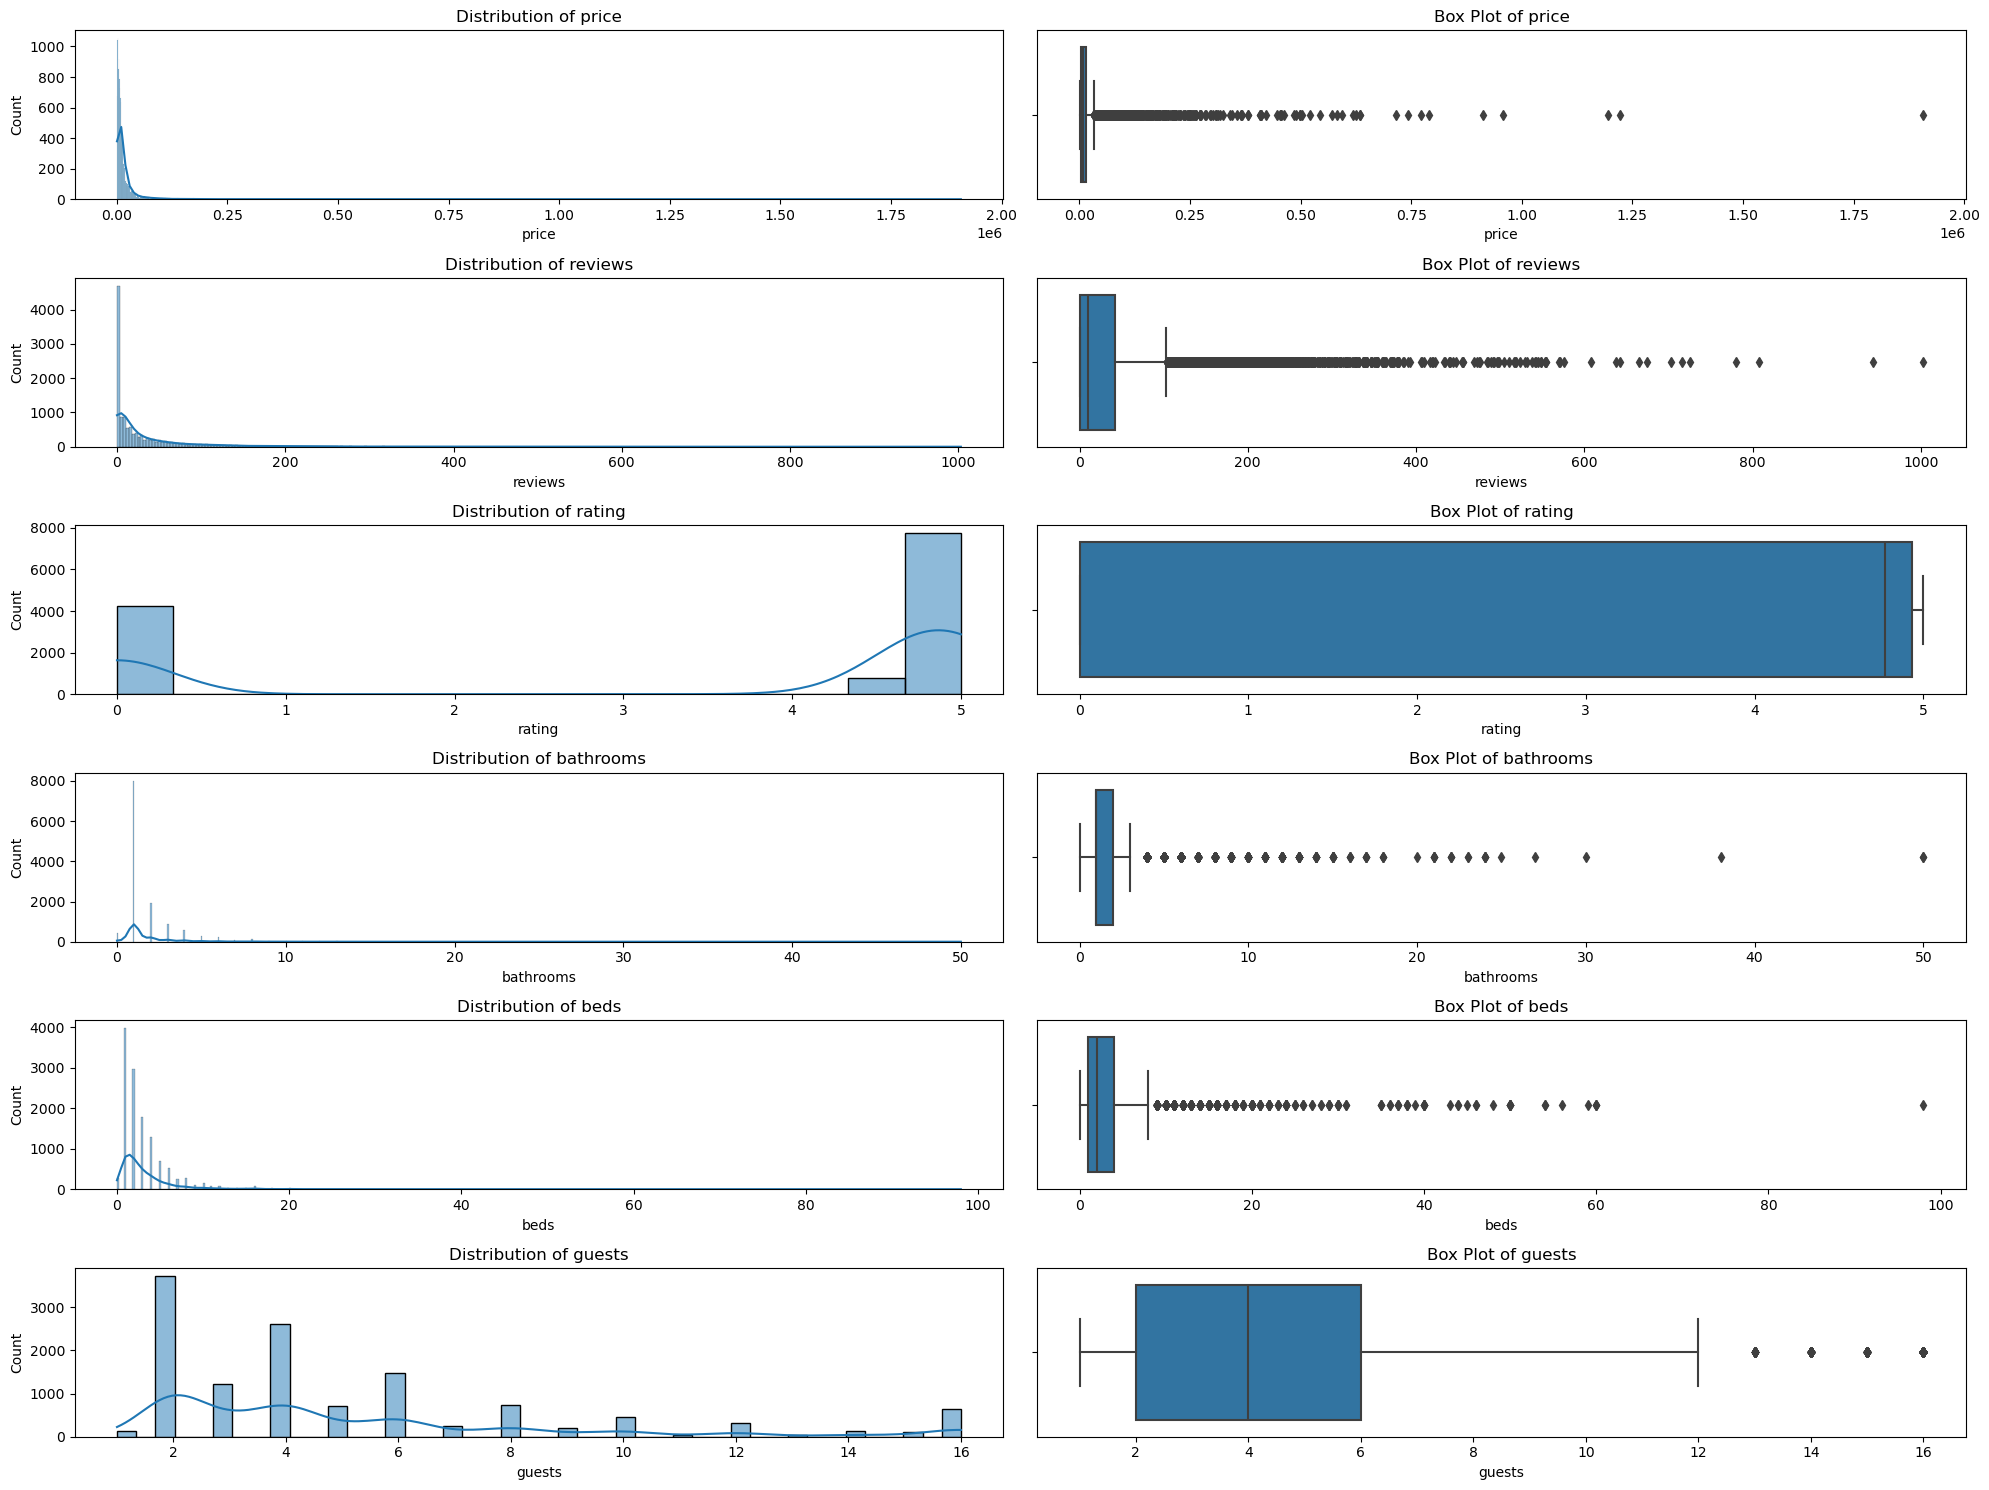

In [43]:
# Function to plot distribution and box plot for specified columns
def plot_distributions(df, columns):
    plt.figure(figsize=(20, 15))
    plot_number = 1

    for column in columns:
        if plot_number <= len(columns) * 2:
            ax = plt.subplot(len(columns), 2, plot_number)
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution of {column}')
            plot_number += 1
            
            ax = plt.subplot(len(columns), 2, plot_number)
            sns.boxplot(x=df[column])
            plt.title(f'Box Plot of {column}')
            plot_number += 1

    plt.tight_layout()
    plt.show()

# Columns to plot and clean
columns_with_outliers = ['price', 'reviews', 'rating', 'bathrooms', 'beds', 'guests']

# Plotting distributions and box plots for specified columns
plot_distributions(airbnb, columns_with_outliers)

In [44]:
def remove_outliers(airbnb, column, threshold=0.99):
  upper_limit = airbnb[column].quantile(threshold)
  return airbnb[airbnb[column] <= upper_limit]

# Columns where you suspect outliers
columns_with_outliers = ['price', 'reviews', 'rating', 'bathrooms', 'beds', 'guests']

# Loop and remove outliers for each column
for column in columns_with_outliers:
  airbnb = remove_outliers(airbnb, column)

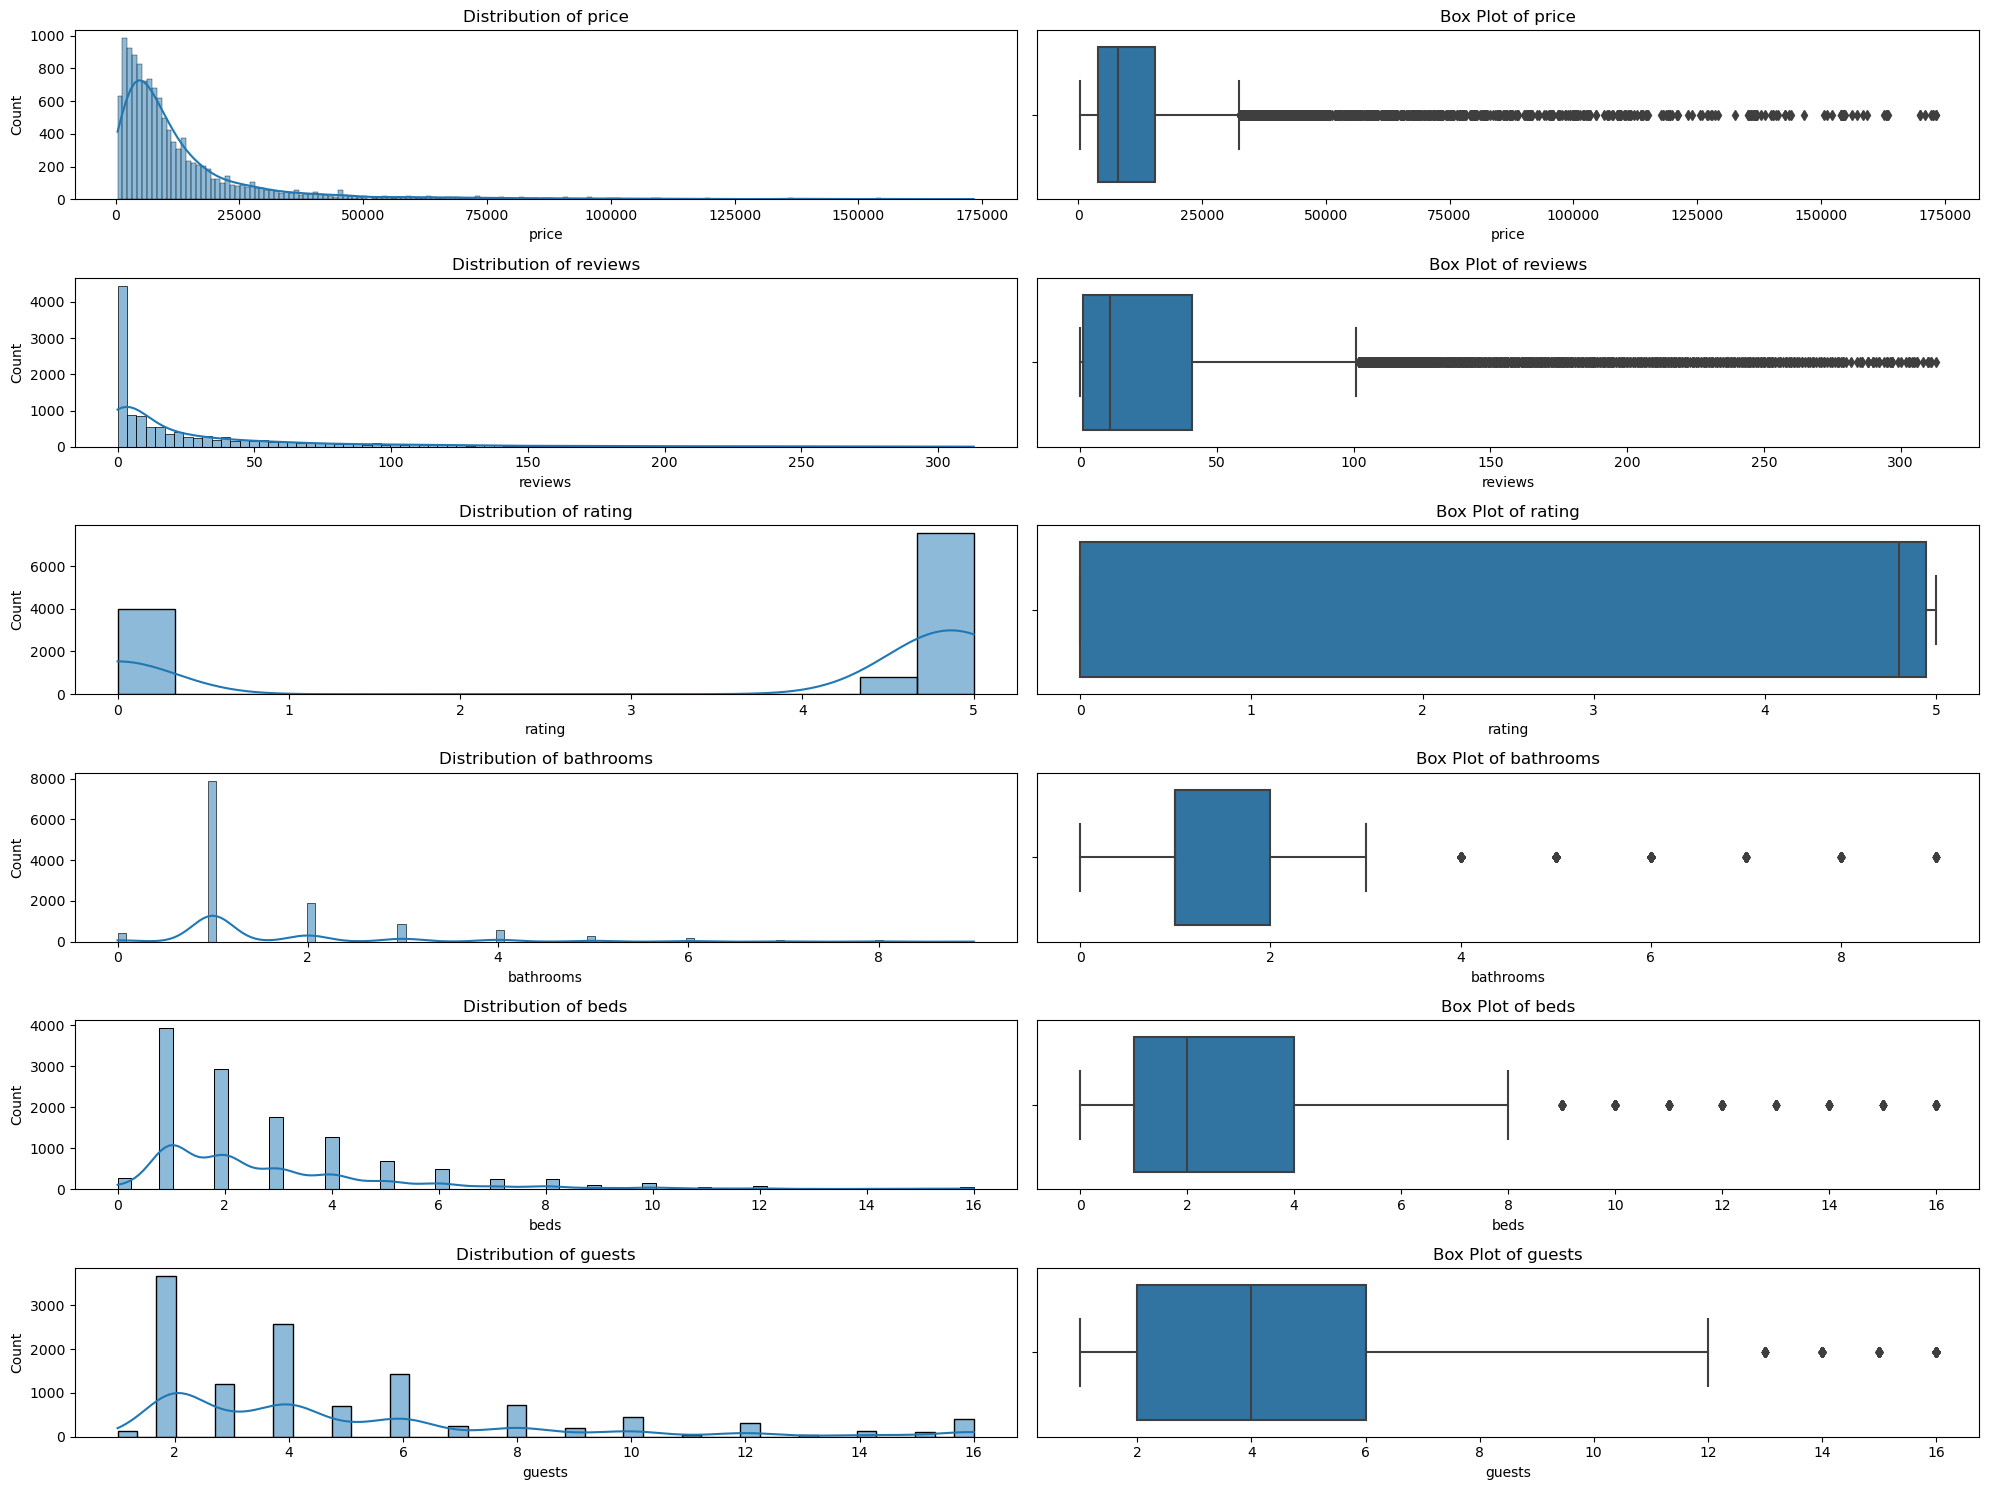

In [45]:
# Function to plot distribution and box plot for specified columns
def plot_distributions(df, columns):
    plt.figure(figsize=(20, 15))
    plot_number = 1

    for column in columns:
        if plot_number <= len(columns) * 2:
            ax = plt.subplot(len(columns), 2, plot_number)
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution of {column}')
            plot_number += 1
            
            ax = plt.subplot(len(columns), 2, plot_number)
            sns.boxplot(x=df[column])
            plt.title(f'Box Plot of {column}')
            plot_number += 1

    plt.tight_layout()
    plt.show()

# Columns to plot and clean
columns_with_outliers = ['price', 'reviews', 'rating', 'bathrooms', 'beds', 'guests']

# Plotting distributions and box plots for specified columns
plot_distributions(airbnb, columns_with_outliers)

In [46]:
#converting data_type
airbnb['host_id'] = pd.to_numeric(airbnb['host_id'], errors='coerce').fillna(0).astype(int)

In [47]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12340 entries, 0 to 12804
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        12340 non-null  int64  
 1   name                      12340 non-null  object 
 2   rating                    12340 non-null  float64
 3   reviews                   12340 non-null  int32  
 4   host_id                   12340 non-null  int32  
 5   price                     12340 non-null  int64  
 6   country                   12340 non-null  object 
 7   bathrooms                 12340 non-null  int64  
 8   beds                      12340 non-null  int64  
 9   guests                    12340 non-null  int64  
 10  toilets                   12340 non-null  int64  
 11  bedrooms                  12340 non-null  int64  
 12  studios                   12340 non-null  int64  
 13  checkin                   12340 non-null  object 
 14  checkout   

## Exporting the Cleaned Customer Demographic Data Set to csv

In [48]:
airbnb.to_csv("Airbnb_Cleaned")